## Vegetable Image Classification

Download Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

Change your dataset folder structure to: <br>

*   input (ROOT)
	*   vegetables
		*   testing_set
			*   broccoli
			*   cabbage
			*   carrot
		*   training_set
			*   broccoli
			*   cabbage
			*   carrot			

## 1. Import Libraries

1. pip install tensorflow==2.10.0
<br>
2. pip install matplotlib

In [8]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras import layers

In [9]:
tf.__version__

'2.10.0'

tensorflow==2.5.0 to tensorflow==2.10.0 is required for gpu to work
<br>
Requirements: 
<br>
cuDNN = 8.1
<br>
CUDA = 11.2

In [10]:
phusical_devices = tf.config.list_physical_devices('GPU')
GPU_COUNT = len(phusical_devices)

print("Num GPUs Available: ", GPU_COUNT)
print(tf.config.list_physical_devices('GPU'))

# USE GPU FOR TRAINING MODEL (GPU is much faster for training)
if(GPU_COUNT > 0):
	tf.config.experimental.set_memory_growth(phusical_devices[0], True)
	print("GPU ENABLED")


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU ENABLED


## 2. Generate the datasets, both the training and the test sets


In [11]:
# define the paths to the dataset.
TRAINING_PATH = './input/vegetables/training_set/'
TEST_PATH = './input/vegetables/testing_set/'

In [36]:
# Create, Load dataset
height, width = 224, 224
image_size = (height, width)

# LOW THE BATCH SIZE IF OOM (OUT OF MEMORY) ERROR OCCURS IN TRAINING
batch_size = 5

subfolder_label_names = ['broccoli', 'cabbage', 'carrot']

print("TRAINING IMAGES COUNT: ")
training_set = keras.preprocessing.image_dataset_from_directory(
    directory=TRAINING_PATH,
    class_names=subfolder_label_names,
    image_size=image_size,
    batch_size=batch_size
)

print("TEST IMAGES COUNT: ")
test_set = keras.preprocessing.image_dataset_from_directory(
    directory=TEST_PATH,
    class_names=subfolder_label_names,
    image_size=image_size,
    batch_size=batch_size,
    
)

# Generate the classes/labels
class_names = training_set.class_names
print(f'Classes: {class_names}')


TRAINING IMAGES COUNT: 
Found 3000 files belonging to 3 classes.
TEST IMAGES COUNT: 
Found 600 files belonging to 3 classes.
Classes: ['broccoli', 'cabbage', 'carrot']


# Visualize some images from the training set

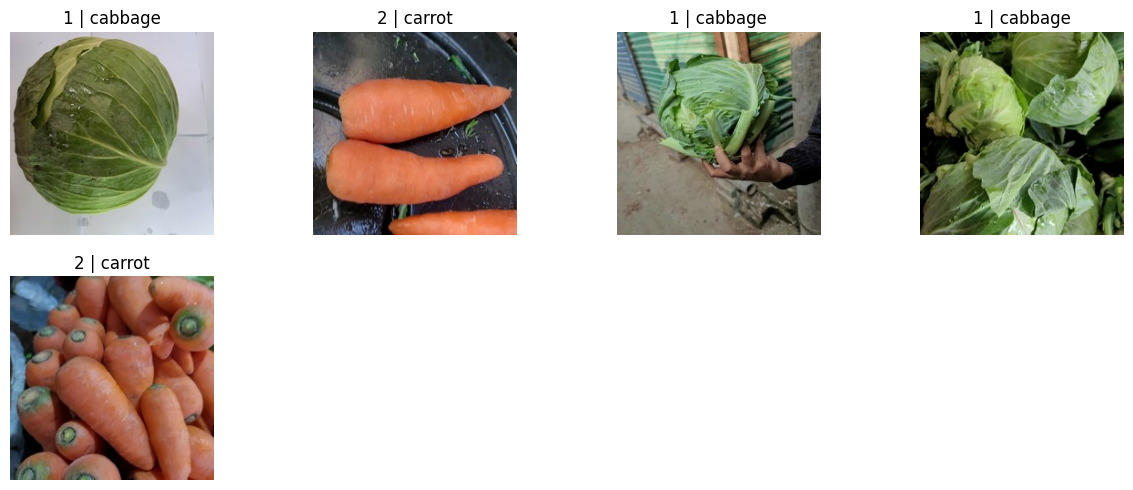

In [34]:
# visualize the training set
plt.figure(figsize=(15, 9))


for images, labels in training_set.take(1):
    for i in range(batch_size):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'{labels[i]} | {class_names[labels[i]]}')
        plt.axis('off')

# Visualize some images from the test set


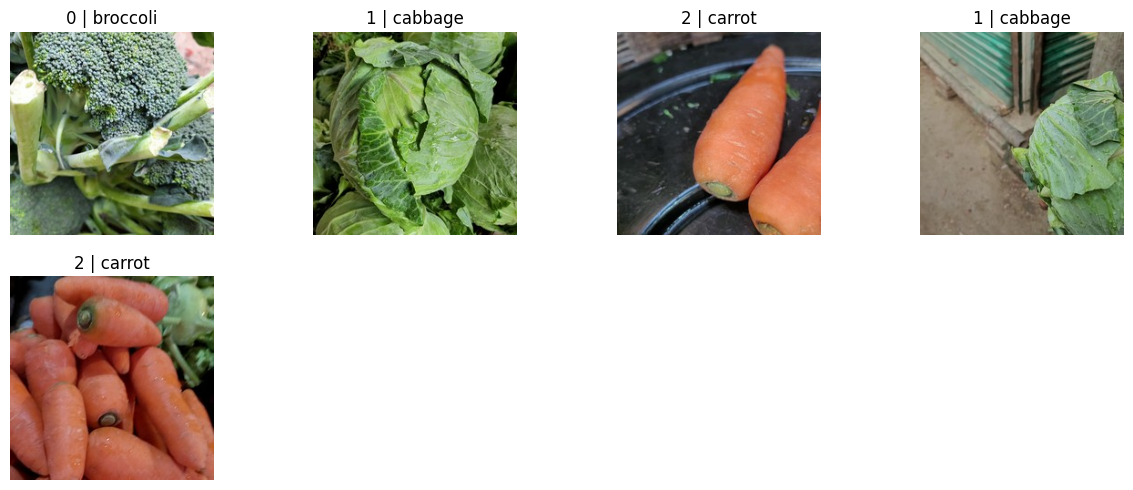

In [35]:
# visualize the training set
plt.figure(figsize=(15, 9))


for images, labels in test_set.take(1):
    for i in range(batch_size):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'{labels[i]} | {class_names[labels[i]]}')
        plt.axis('off')

Data Augmentation, in its essence, means to generate new data by modifying existing data.

Code below is an example:

In [15]:
# define some layers of data augmentation
augmented_data = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])

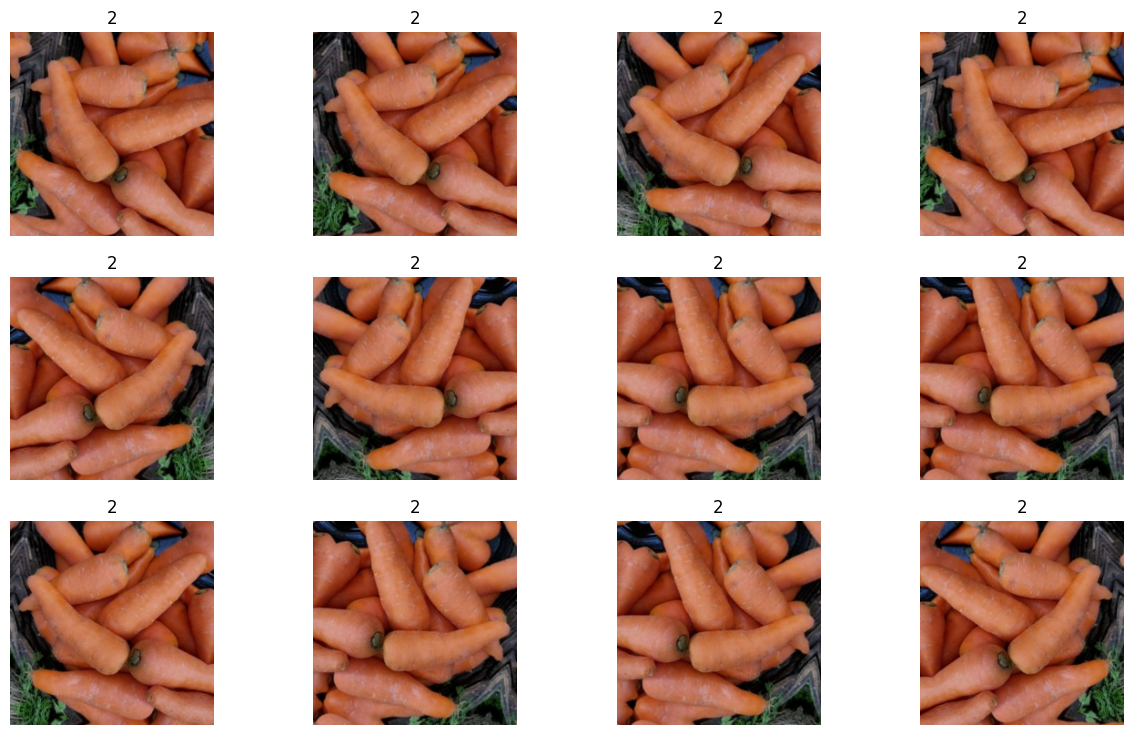

In [16]:
# visualize it
plt.figure(figsize=(15, 9))
    
for images, labels in test_set.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        augmented_image = augmented_data(images[0])
        plt.imshow(augmented_image.numpy().astype('uint8'))
        plt.title(int(labels[0]))
        plt.axis('off')

## 3. Build the CNN model


The first layer in the model is a 2-dimensional convolutional layer. This layer will have 128 output filters each with a kernel size of 3x3, and we’ll use the relu activation function.

Note that the choice for the number of output filters specified is arbitrary, and the chosen kernel size of 3x3 is generally a very common size to use. You can experiment by choosing different values for these parameters.

We enable zero-padding by specifying padding = 'same'.

Sigmoid is used for binary classification methods where we only have 2 classes, while SoftMax applies to multiclass problems. In fact, the SoftMax function is an extension of the Sigmoid function.

In [17]:
# build the model
model = Sequential([

	# 1. Step 1 - Convolution
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(height, width, 3)),
    
    # preprocessing - SCALE FIRST BEFORE AUGMENTATION
    layers.CenterCrop(180, 180),
    layers.Rescaling(scale=1./255),
    
    
    # applying image data augmentation
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),

    # Add BatchNormalization()
    layers.BatchNormalization(),

	# Step 2 - Pooling
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

	# Adding a more convolutional layer
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    # Add BatchNormalization()
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    # Add BatchNormalization()
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    
	# Step 3 - Flattening
    layers.Flatten(),

	# Step 4 - Full Connection
	layers.Dense(units=256, activation='relu'),

	# Optional for improvement (Dropout reduces overfitting of nueral networks)
	layers.Dropout(0.25),
    
    # Step 5 - Output Layer
    layers.Dense(len(subfolder_label_names), activation='softmax')
])

In this type of problem, we have more than 2 classes that's why softmax is the activation function used in the output layer, if the problem has only 1-2 classes then it's binary which is a sigmoid activation will be used instead.

In [18]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 center_crop (CenterCrop)    (None, 180, 180, 128)     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 128)     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 128)     0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 128)    0         
 tation)                                                         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 128)    512       
 ormalization)                                        

## 4. Train the model

sparse_categorical_crossentropy is used as a loss function because we are dealing with multiple classes, on the other hand if we are dealing with binary classification we will use binary_crossentropy.

In [19]:
epochs = 25

# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# fit the model
model.fit(training_set, validation_data=test_set, epochs=epochs, verbose=2)

Epoch 1/25
600/600 - 88s - loss: 0.5069 - accuracy: 0.8677 - val_loss: 1.4370 - val_accuracy: 0.6750 - 88s/epoch - 147ms/step
Epoch 2/25
600/600 - 70s - loss: 0.2162 - accuracy: 0.9277 - val_loss: 1.9721 - val_accuracy: 0.6883 - 70s/epoch - 117ms/step
Epoch 3/25
600/600 - 70s - loss: 0.2845 - accuracy: 0.9110 - val_loss: 4.1706 - val_accuracy: 0.6650 - 70s/epoch - 117ms/step
Epoch 4/25
600/600 - 70s - loss: 0.1523 - accuracy: 0.9517 - val_loss: 0.0873 - val_accuracy: 0.9783 - 70s/epoch - 117ms/step
Epoch 5/25
600/600 - 71s - loss: 0.1556 - accuracy: 0.9480 - val_loss: 0.6188 - val_accuracy: 0.7067 - 71s/epoch - 118ms/step
Epoch 6/25
600/600 - 70s - loss: 0.1365 - accuracy: 0.9590 - val_loss: 0.3315 - val_accuracy: 0.8917 - 70s/epoch - 117ms/step
Epoch 7/25
600/600 - 70s - loss: 0.1239 - accuracy: 0.9593 - val_loss: 0.2687 - val_accuracy: 0.9083 - 70s/epoch - 116ms/step
Epoch 8/25
600/600 - 70s - loss: 0.0976 - accuracy: 0.9680 - val_loss: 0.4918 - val_accuracy: 0.9283 - 70s/epoch - 117

## Evaluate Model

Using the test dataset, evaluate the model accuracy

In [25]:
loss, acc = model.evaluate(test_set)
print(f"Accuracy {acc}")

120/120 [==============================] - 3s 22ms/step - loss: 0.3386 - accuracy: 0.8050
Accuracy 0.8050000071525574


### Save Model

In [20]:
model.save('vegetable_classification_model', save_format='h5');

## 5. Visualize the predicted images


1/1 [==============================] - 0s 317ms/step


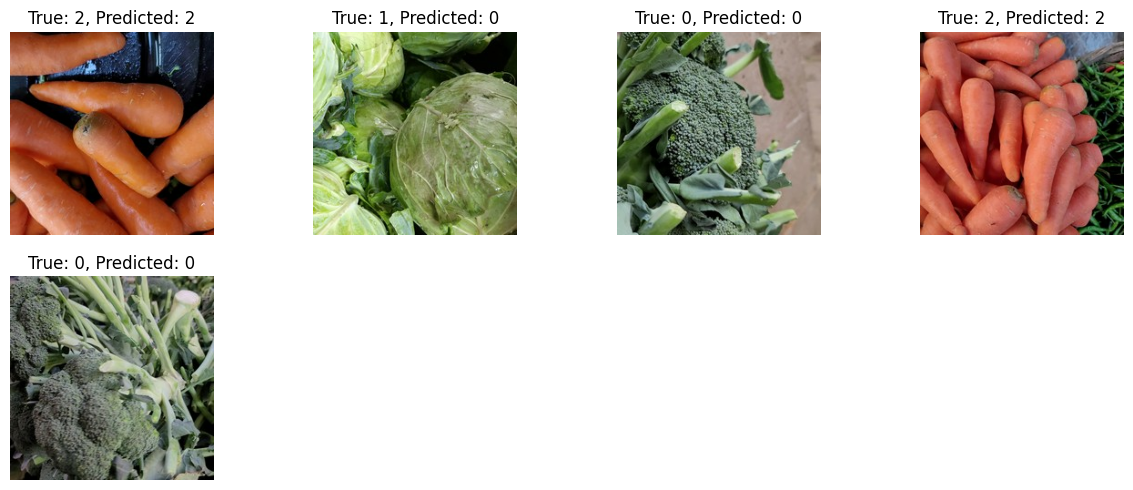

In [24]:
# It can be used to reconstruct the model identically.
saved_model = keras.models.load_model("vegetable_classification_model")

plt.figure(figsize=(15, 9))

def predict(images):
    pred = []
    for i in saved_model.predict(images.numpy().astype('uint8')):
        prediction_index = np.argmax(i)
        pred.append(prediction_index)
    return pred
    
for images, labels in test_set.take(1):
    pred = predict(images)
    for i in range(batch_size):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {int(labels[i])}, Predicted: {pred[i]}')
        plt.axis('off')

1/1 [==============================] - 0s 38ms/step
['broccoli', 'cabbage', 'carrot']
[[0.47117338 0.5066195  0.02220717]]
cabbage


(-0.5, 649.5, 499.5, -0.5)

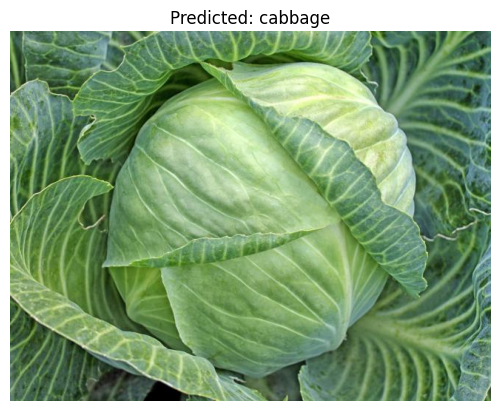

In [29]:
import numpy as np
from keras.utils import load_img
from keras.utils import img_to_array
import matplotlib.image as mpimg

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img

#cabbage_test.jpg
#broccoli_test.jpg

PATH_OF_IMAGE = './cabbage_test.jpg'

test_image = load_img(PATH_OF_IMAGE, target_size = image_size)
test_image = img_to_array(test_image)
test_image = np.array([test_image])  # Convert single image to a batch.

prediction = saved_model.predict(test_image)

prediction_index = np.argmax(prediction)

# train_set.class_names
# or ['broccoli', 'cabbage', 'carrot']
classes = training_set.class_names

prediction_output = classes[prediction_index]

print(prediction)
print(prediction_output)

img = mpimg.imread(PATH_OF_IMAGE)
plt.imshow(img)
plt.title(f'Predicted: {prediction_output}')
plt.axis('off')


## REFERENCE NOTEBOOKS <br>

[1] https://www.kaggle.com/code/mayank2896/vegetable-classification-computer-vision <br>
[2] https://www.kaggle.com/code/hikmatullahmohammadi/keras-cats-vs-dogs-classification-step-by-step